In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [16]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import h5py
import seaborn as sns
from sklearn import datasets, linear_model
from tqdm.notebook import tqdm
import random
import math
import json

In [3]:
# sys.path.insert(0, "../")
# from con_score import *
# from deeprepviz_generator import *

In [5]:
! python create_shapes_data.py -n 15

(15, 15)
Generating 15 sythetic images:
100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  7.55it/s]


In [9]:
a = np.load("/ritter/roshan/workspace/Deep-confound-control/experiments_sim/shapes/y_data.npy")
a.shape

(15, 15)

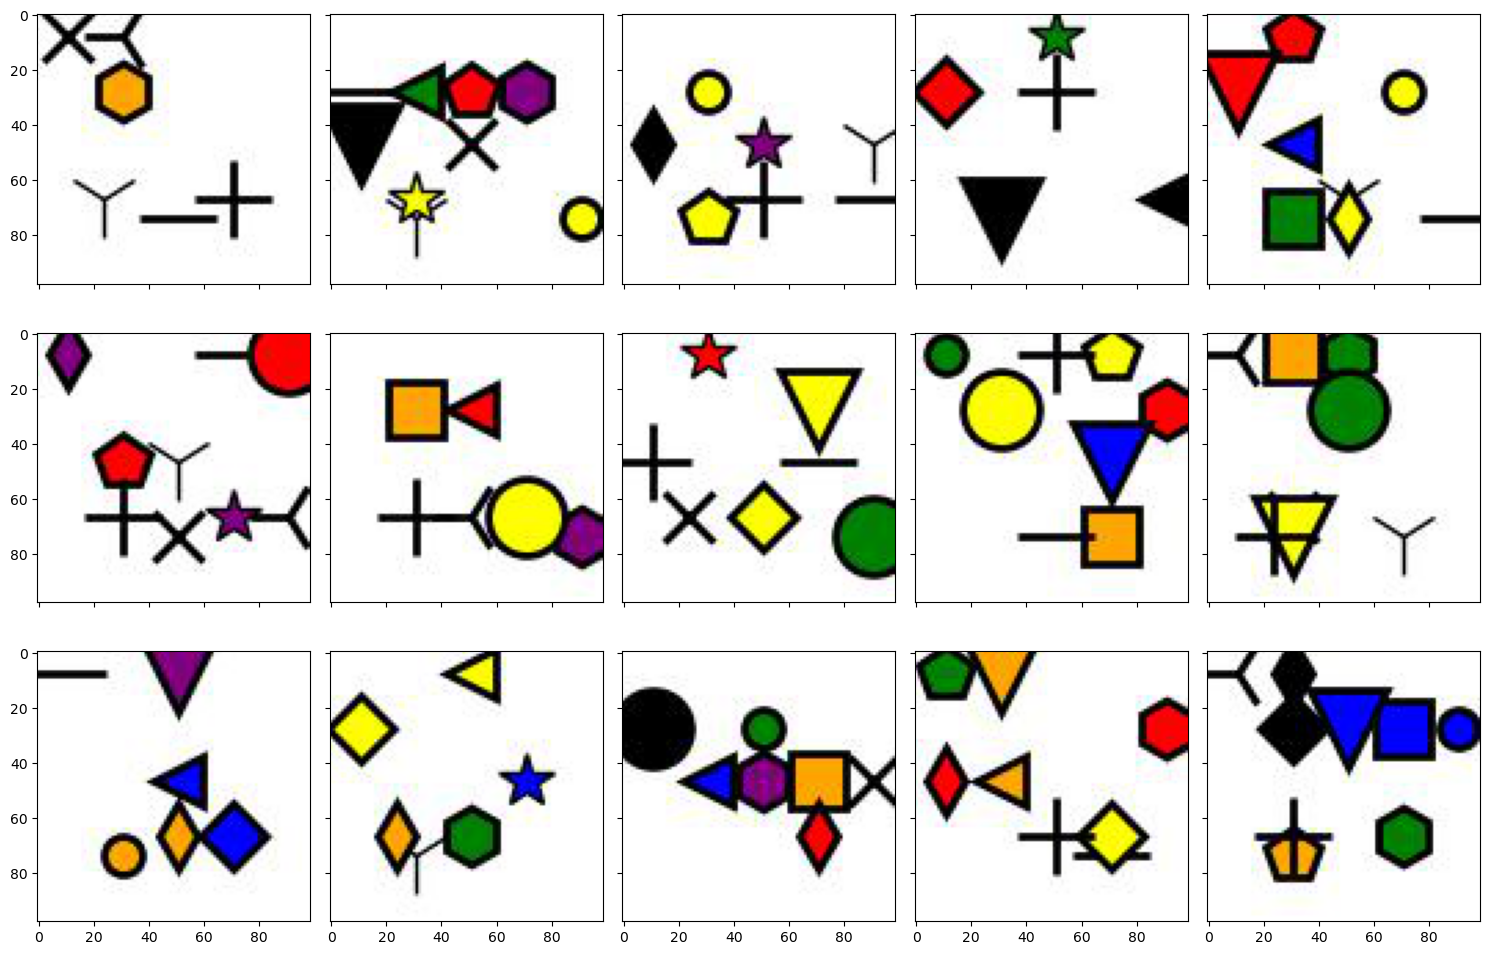

In [33]:
f, axes = plt.subplots(3,5, figsize=(15,10), sharex=True, sharey=True)
axes = axes.ravel()

for i, img_file in enumerate(glob("shapes/images/*.jpg")):
    if i<len(axes):
        img=mpimg.imread(img_file)
        ax = axes[i]
        ax.imshow(img)
        # ax.axis('off')
plt.tight_layout()

In [258]:
ColorDict()

{'amethyst': (100.0, 96.0, 154.0),
 'citrine': (147.0, 55.0, 9.0),
 'emerald': (20.0, 169.0, 137.0),
 'jade': (70.0, 154.0, 132.0),
 'jasper': (208.0, 83.0, 64.0),
 'lapislazuli': (67.0, 108.0, 185.0),
 'malachite': (70.0, 148.0, 150.0),
 'moonstone': (58.0, 168.0, 193.0),
 'onyx': (53.0, 56.0, 57.0),
 'peridot': (171.0, 173.0, 72.0),
 'pinkpearl': (176.0, 112.0, 128.0),
 'rosequartz': (189.0, 85.0, 156.0),
 'ruby': (170.0, 64.0, 105.0),
 'sapphire': (45.0, 93.0, 161.0),
 'smokeytopaz': (131.0, 42.0, 13.0),
 "tiger'seye": (181.0, 105.0, 23.0),
 'radicalred': (255.0, 53.0, 94.0),
 'wildwatermelon': (253.0, 91.0, 120.0),
 'outrageousorange': (255.0, 96.0, 55.0),
 'atomictangerine': (255.0, 153.0, 102.0),
 'neoncarrot': (255.0, 153.0, 51.0),
 'sunglow': (255.0, 204.0, 51.0),
 'laserlemon': (255.0, 255.0, 102.0),
 'electriclime': (204.0, 255.0, 0.0),
 "screamin'green": (102.0, 255.0, 102.0),
 'magicmint': (170.0, 240.0, 209.0),
 'blizzardblue': (80.0, 191.0, 230.0),
 'shockingpink': (255.0

In [504]:
ColorDict()['peach']

(255.0, 208.0, 185.0)

#### All generative variables
1. 'brain_vol' # total volume of the brain ranging between 1633 to 2261 [(S/2-12)*(S/2-6) to (S/2-8)*(S/2-2)]
2. 'brain_thick' # the thickness of the blue border around the brain ranging between 1 to 4
3. 'brain_int', # the intensity or brightness of the brain region ranging between 'greyness0' to 'greyness4'

#### Confounds
2. `age ~ brain_vol & vent_thick` such that `up(age) -> up(vent_thick)` `up(age) -> down(brain_vol)`
3. `sex ~ brain_vol` as a intermediary causal variable such that `male ~ large(brain vol)` `female ~ small(brain vol)`
4. `site ~ outline_color & brain_int` such that 
4. Find citations for (2) and (3)
5. add lesions? 
6. ~add a shape {triangle, square, pentagon, hexagon, ..} at top bottom right and left~

#### Labels
1. purely based on 4 shapes (combinations that are linear and non-linear)
2. partially based on confounder + partially shapes : see the idea from MDN
3. purely based on confounder pathway
4. Create a brain_mask and save it as a label

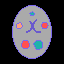

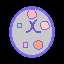

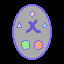

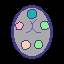

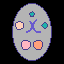

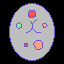

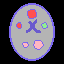

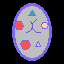

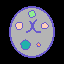

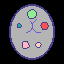

In [505]:

S = 64 # image size = (S X S)
n_samples = 10


In [326]:
df_gen

,brain_vol,brain_thick,brain_int,vent_thick,vent_color,frontal_shape,frontal_thick,frontal_color,frontal_vol,caudal_shape,caudal_thick,caudal_color,caudal_vol,brain_color
subjectID,,,,,,,,,,,,,,
0,2023.185669,1,NaN,2,slateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness2
1,1866.106036,2,NaN,1,mediumslateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness3
2,2004.336113,2,NaN,3,slateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness3
3,1759.291886,2,NaN,1,mediumslateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness4
4,2004.336113,1,NaN,1,mediumslateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness1
5,1759.291886,1,NaN,1,slateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness1
6,1715.309589,1,NaN,1,slateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness1
7,1796.990998,1,NaN,2,mediumslateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness4
8,1822.123739,3,NaN,3,slateblue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,greyness3


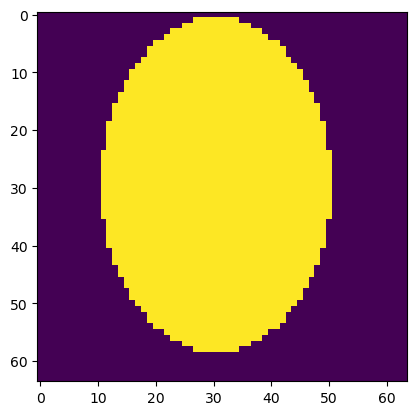

In [247]:
img_arr = (np.array(image).sum(axis=-1)>0)
plt.imsave('filename.png', img_arr, cmap=cm.gray)

In [352]:
def get_random_num(a, b):
    options = [1, 2, 3, 4]
    if a:
        lambd = 2
        weights = [poisson.pmf(i, lambd) for i in range(len(options))]
        weights = np.array(weights) / np.sum(weights)
    elif a:
        # If a is True and b is False, return 1 or 4 with different probabilities
        options = [1, 4]
        lambd = 1.5
        weights = [poisson.pmf(i, lambd) for i in range(len(options))]
        weights = np.array(weights) / np.sum(weights)
        num = np.random.choice(options, p=weights)
    elif b:
        # If b is True and a is False, return 2 or 3 with higher probability than 1 or 4
        options = [1, 2, 3, 4]
        lambd = 1.5
        weights = [poisson.pmf(i, lambd) for i in range(len(options))]
        weights = np.array(weights) / np.sum(weights)
        num = np.random.choice(options, p=weights)
    else:
        # If both a and b are False, return 1, 2, 3, or 4 with equal probability
        options = [1, 2, 3, 4]
        lambd = 1
        weights = [poisson.pmf(i, lambd) for i in range(len(options))]
        weights = np.array(weights) / np.sum(weights)
        num = np.random.choice(options, p=weights)

    num = np.random.choice(options, p=weights)
    
    return num


In [497]:
import numpy as np

def smooth_array(arr, window):



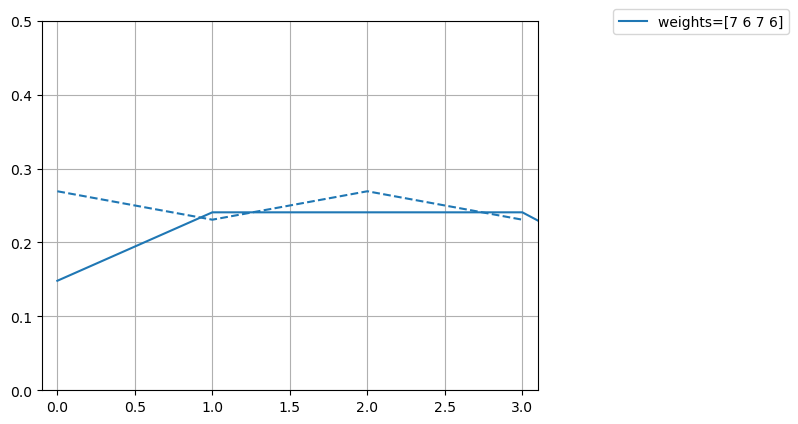

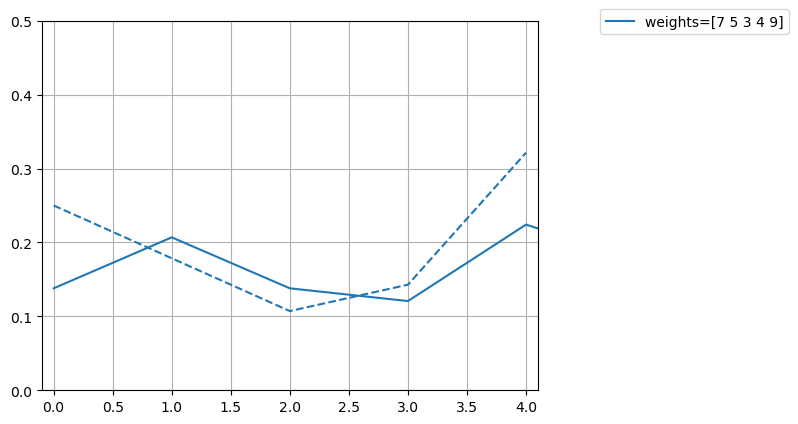

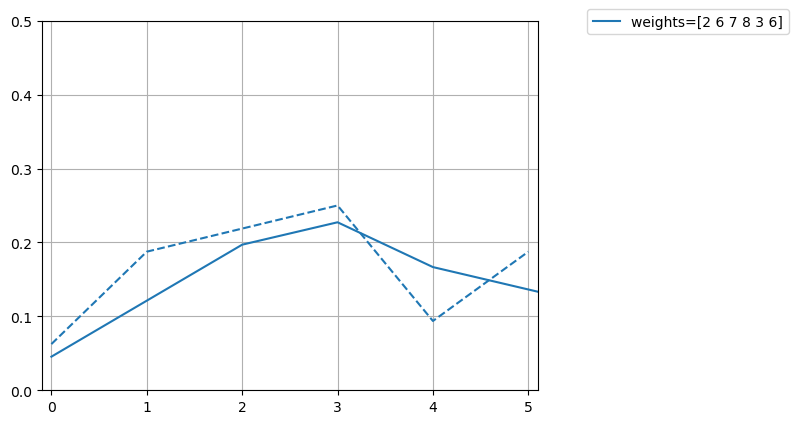

In [500]:
cmap = plt.get_cmap('tab10')
trials = 1
for k in range(4,7):
    f, ax = plt.subplots()
    for i in range(trials):
        color = cmap
        weights = np.random.randint(1,10, size=k)
        plt.plot(weights/sum(weights), ls='--', label=None, color=cmap(i))
        pdf = smooth_array(weights,2)
        pdf = pdf/pdf.sum() #+gamma.pdf(x=weights[::-1], a=k)/2
        plt.plot(pdf, label=f"weights={weights}", color=cmap(i))
        
    plt.gca().set(xlim=[-0.1,k-0.9], ylim=[0,0.5])
    plt.legend(loc="upper right", bbox_to_anchor=(1.52, 1.05))
    plt.grid(True)
    plt.show()

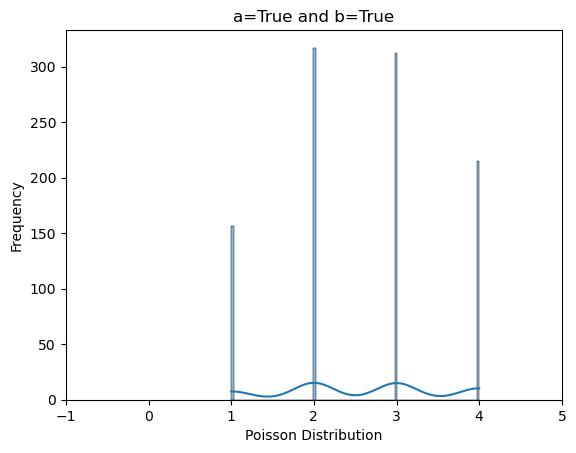

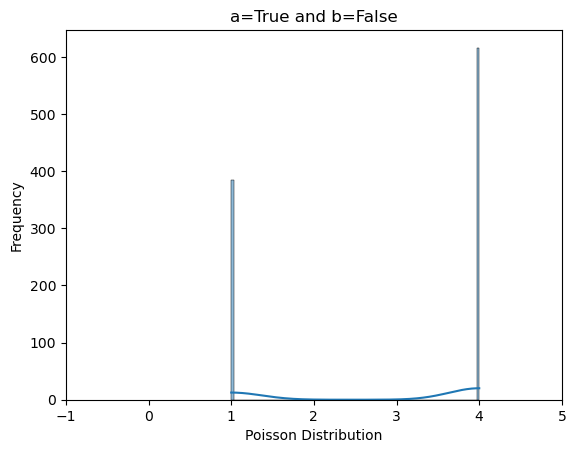

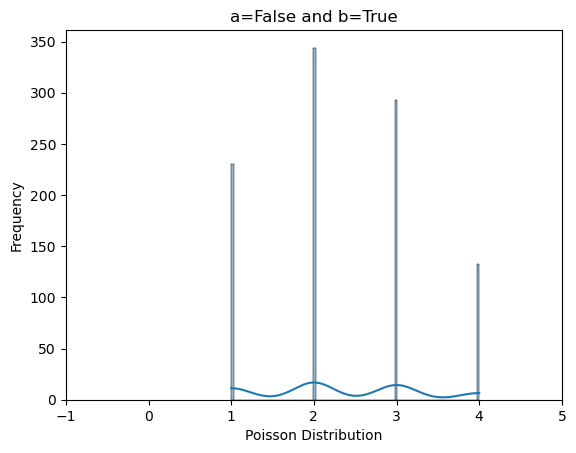

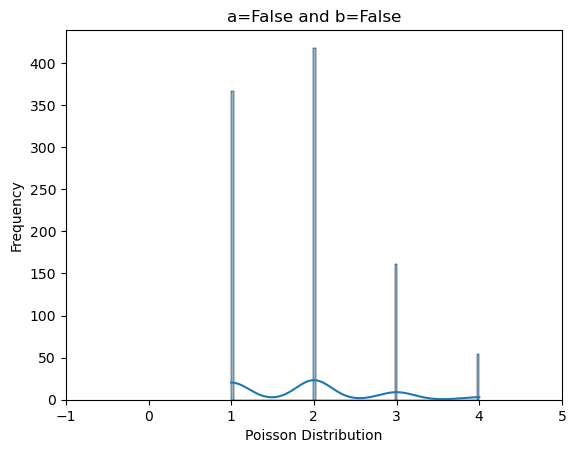

In [354]:
from scipy.stats import poisson
for a in [True, False]:
    for b in [True, False]:
        nums = [get_random_num(a,b) for i in range(1000)]
        ax = sns.histplot(nums,
                          kde=True,
                          bins=100)
        ax.set(xlabel='Poisson Distribution', ylabel='Frequency', title=f"a={a} and b={b}", xlim=[-1,5])
        plt.show()

(40.0, 40.0, 100.0, 100.0) (100.0, 40.0, 160.0, 100.0)


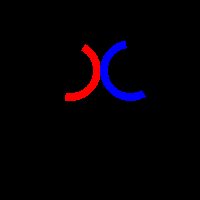

In [237]:
from PIL import Image, ImageDraw
S=200
# Create a new image with a black background
img = Image.new("RGB", (S, S), color="black")

# Draw two arcs at the center of the image, facing opposite to each other and touching at the center
draw = ImageDraw.Draw(img)
x_off, y_off= 0,0
xy_r = (S*.2, S*.2, S*.5, S*.5)
xy_l = (S*.5, S*.2, S*.8, S*.5)
print(xy_r, xy_l)
draw.arc(xy_r, start=300, end=100,   fill="red",  width=8)
draw.arc(xy_l, start=-300, end=-100, fill="blue", width=8)

# Show the image
img

In [ ]:
colors